# Testbed for blurring of simulations

### Plotting Imports

In [1]:
#Lets have matplotlib "inline"
%matplotlib inline

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset
import datetime
from IPython.display import display

#For plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["lines.color"] = "w"
plt.rcParams["text.color"] = "w"
plt.rcParams["axes.labelcolor"] = "w"
plt.rcParams["xtick.color"] = "w"
plt.rcParams["ytick.color"] = "w"

### GPUocean Imports

In [2]:
from gpuocean.SWEsimulators import CDKLM16
from gpuocean.utils import IPythonMagic, Common

In [3]:
%cuda_context_handler gpu_ctx

In [4]:
from IPython.display import clear_output
from matplotlib import animation, rc
plt.rcParams["animation.html"] = "jshtml"
from mpl_toolkits.axes_grid1 import make_axes_locatable

from gpuocean.utils import PlotHelper
from gpuocean.utils.NetCDFInitialization import depth_integration

def plotSolution(fig, 
                 eta, hu, hv, h, dx, dy, 
                 t, comment,
                 h_min=-0.5, h_max=0.5, 
                 uv_min=-3, uv_max=3,
                 calc_uv = False, 
                 add_extra=False,
                 reduced_gravity_interface=None,
                 ax=None, sp=None):


    from datetime import timedelta
    fig.suptitle("Time = {:0>8} ({:s})".format(str(timedelta(seconds=int(t))), comment), 
                 fontsize=18,
                 horizontalalignment='left')
    
    ny, nx = eta.shape
    domain_extent = [0, nx*dx, 0, ny*dy]
    
    x_plots = 3
    y_plots = 1
    if (add_extra == True):
        x_plots=3
        y_plots=2
    
    V_max = 3 * (uv_max-uv_min) / np.max(h)
    R_min = -V_max/2000
    R_max = V_max/2000
   
    huv_label = ["hu","hv"]
    if calc_uv:
        """plotting actually u and v"""
        if reduced_gravity_interface is None or reduced_gravity_interface == 0.0:
            hu = hu/(h+eta)
            hv = hv/(h+eta)
        else:
            hu = hu/(reduced_gravity_interface+eta)
            hv = hv/(reduced_gravity_interface+eta)
        uv_min = -3
        uv_max = +3
        huv_label = ["u","v"]
        h_minmax = np.abs(eta).max()
        h_min, h_max = -h_minmax, h_minmax

    if (ax is None):
        ax = [None]*x_plots*y_plots
        sp = [None]*x_plots*y_plots

        uv_cmap = plt.cm.coolwarm
        uv_cmap.set_bad("grey", alpha = 1.0)
        
        h_cmap = plt.cm.coolwarm
        h_cmap.set_bad("grey", alpha = 1.0)

        ax[0] = plt.subplot(y_plots, x_plots, 1)
        sp[0] = ax[0].imshow(eta, interpolation="none", origin='lower', 
                             cmap=h_cmap, 
                             vmin=h_min, vmax=h_max, 
                             extent=domain_extent)
        plt.axis('image')
        plt.title("$\zeta{}$")
        divider0 = make_axes_locatable(ax[0])
        cax0 = divider0.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(sp[0],cax=cax0)


        ax[1] = plt.subplot(y_plots, x_plots, 2)
        sp[1] = ax[1].imshow(hu, interpolation="none", origin='lower', 
                            cmap=uv_cmap, 
                            vmin=uv_min, vmax=uv_max, 
                            extent=domain_extent)
        plt.axis('image')
        plt.title("$"+huv_label[0]+"$")
        divider1 = make_axes_locatable(ax[1])
        cax1 = divider1.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(sp[1],cax=cax1)



        ax[2] = plt.subplot(y_plots, x_plots, 3)
        sp[2] = ax[2].imshow(hv, interpolation="none", origin='lower', 
                             cmap=uv_cmap, 
                             vmin=uv_min, vmax=uv_max, 
                             extent=domain_extent)
        plt.axis('image')
        plt.title("$"+huv_label[1]+"$")
        divider2 = make_axes_locatable(ax[2])
        cax2 = divider2.append_axes('right', size='5%', pad=0.05)
        fig.colorbar(sp[2],cax=cax2)

        plt.tight_layout()
            
    else:        
        #Update plots
        fig.sca(ax[0])
        sp[0].set_data(eta)
        
        fig.sca(ax[1])
        sp[1].set_data(hu)
        
        fig.sca(ax[2])
        sp[2].set_data(hv)
        
        if (add_extra == True):
            V = PlotHelper.genVelocity(h, hu, hv)
            fig.sca(ax[3])
            sp[3].set_data(V)

            R = PlotHelper.genColors(h, hu/dx, hv/dy, plt.cm.seismic, R_min, R_max)
            fig.sca(ax[4])
            sp[4].set_data(R)
    
    return ax, sp

def ncAnimation(filename, movie_frames=None, create_movie=True, fig=None, x0=0, x1=-1, y0=0, y1=-1, reduced_gravity_interface=None, **kwargs):
    #Create figure and plot initial conditions
    if fig is None:
        fig = plt.figure(figsize=(24, 4))

    try:
        ncfile = Dataset(filename)
        try:
            x = ncfile.variables['x'][:]
        except:
            x = ncfile.variables['X'][x0:x1]
        try:
            y = ncfile.variables['y'][:]
        except:
            y = ncfile.variables['Y'][y0:y1]
        t = ncfile.variables['time'][:]

        try:
            H_m = ncfile.variables['Hm'][:,:]
        except:
            H_m = ncfile.variables['h'][y0:y1,x0:x1]
        try:
            eta = ncfile.variables['eta'][:,:,:]
        except:
            eta = ncfile.variables['zeta'][:,y0:y1,x0:x1]
        try:
            hu = ncfile.variables['hu'][:,:,:]
            calc_uv = True
        except:
            if reduced_gravity_interface is None:
                hu = ncfile.variables['ubar'][:,y0:y1,x0:x1]
                calc_uv = False
            else:
                if reduced_gravity_interface > 0.0:
                    hu = np.ma.zeros(eta.shape)
                    for t_idx in range(len(t)):
                        hu[t_idx] = depth_integration(ncfile, reduced_gravity_interface, x0, x1, y0, y1, "u", timestep_index=t_idx)
                    calc_uv = True
                else:
                    hu = ncfile.variables['u'][:,0,y0:y1,x0:x1]
                    calc_uv = False
        try:
            hv = ncfile.variables['hv'][:,:,:]
        except:
            if reduced_gravity_interface is None:
                hv = ncfile.variables['vbar'][:,y0:y1,x0:x1]
            else:
                if reduced_gravity_interface > 0.0:
                    hv = np.ma.zeros(eta.shape)
                    for t_idx in range(len(t)):
                        hv[t_idx] = depth_integration(ncfile, reduced_gravity_interface, x0, x1, y0, y1, "v", timestep_index=t_idx)
                else:
                    hv = ncfile.variables['v'][:,0,y0:y1,x0:x1]
                    
    except Exception as e:
        raise e
    finally:
        ncfile.close()


    if movie_frames is None:
        movie_frames = len(t)

    dx = x[1] - x[0]
    dy = y[1] - y[0]
    
    progress = Common.ProgressPrinter(5)

    if (create_movie):
        ax, sp = plotSolution(fig, 
                              eta[0],
                              hu[0],
                              hv[0],
                              H_m+eta[0],
                              dx, dy, 
                              t[0], "Initalised from Mixed Layer Daily-Average",
                              calc_uv=calc_uv,
                              reduced_gravity_interface=reduced_gravity_interface,
                              **kwargs)
    else:
        ax, sp = plotSolution(fig, 
                              eta[-1],
                              hu[-1],
                              hv[-1],
                              H_m+eta[-1],
                              dx, dy, 
                              t[-1], filename,
                              calc_uv=calc_uv,
                              **kwargs)
        return

    #Helper function which simulates and plots the solution    
    def animate(i):
        t_now = t[0] + (i / (movie_frames-1)) * (t[-1] - t[0]) 

        k = np.searchsorted(t, t_now)
        if (k >= eta.shape[0]):
            k = eta.shape[0] - 1
        j = max(0, k-1)
        if (j == k):
            k += 1
        s = (t_now - t[j]) / (t[k] - t[j])

        plotSolution(fig, 
                        (1-s)*eta[j] + s*eta[k], 
                        (1-s)*hu[j]  + s*hu[k], 
                        (1-s)*hv[j]  + s*hv[k], 
                        H_m+(1-s)*eta[j] + s*eta[k], 
                        dx, dy, 
                        t_now, "Initalised from Mixed Layer Daily-Average",
                        calc_uv=calc_uv,
                        reduced_gravity_interface=reduced_gravity_interface,
                        **kwargs, ax=ax, sp=sp)

        clear_output(wait = True)
        #print(progress.getPrintString(i / (movie_frames-1)))

    #Matplotlib for creating an animation
    anim = animation.FuncAnimation(fig, animate, range(movie_frames), interval=250)
    plt.close(fig)
    
    return anim


## Problem SetUp

In [5]:
def GCbumb(dataShape, amp):

    eta = np.zeros(dataShape)

    R = 25
    for i in range(dataShape[0]):
        for j in range(dataShape[1]):
            dist = np.linalg.norm(np.array([i,j]) - np.array([dataShape[0]/2,dataShape[1]/2]))

            distGC = 0.0
            if dist/R < 1: 
                distGC = 1 - 5/3*(dist/R)**2 + 5/8*(dist/R)**3 + 1/2*(dist/R)**4 - 1/4*(dist/R)**5
            elif dist/R >= 1 and dist/R < 2:
                distGC = 4 - 5*(dist/R) + 5/3*(dist/R)**2 + 5/8*(dist/R)**3 -1/2*(dist/R)**4 + 1/12*(dist/R)**5 - 2/(3*(dist/R))
            eta[i,j] = amp * distGC

    return eta

In [6]:
def geostrophicCurrents(eta, g, f, H, dx, dy):

    dataShape = eta.shape

    dx_eta = np.zeros_like(eta)
    dy_eta = np.zeros_like(eta)

    for i in range(dataShape[1]):
        for j in range(dataShape[0]):
            Dx = 0
            if i<dataShape[0]-1:
                x_up = eta[j,i+1]
                Dx += dx
            else:
                x_up = eta[j,i]
            if i>0:
                x_down = eta[j,i-1]
                Dx += dx
            else:
                x_down = eta[j,i]
            if Dx != 0:
                dx_eta[j,i] = (x_up - x_down)/Dx
            else: 
                dx_eta[j,i] = 0
                    
            Dy = 0
            if j<dataShape[1]-1:
                y_up = eta[j+1,i]
                Dy += dy
            else:
                y_up = eta[j,i]
            if j>0:
                y_down = eta[j-1,i]
                Dy += dy
            else:
                y_down = eta[j,i]
            if Dy != 0:
                dy_eta[j,i] = (y_up - y_down)/Dy
            else: 
                dy_eta[j,i] = 0  

    hu = -g/f * (eta + H) * dy_eta
    hv = g/f * (eta + H) * dx_eta

    return hu, hv



In [7]:
def inits(g, H, amp):
    dx, dy = 800, 800
    nx, ny = 201, 201

    dt = 10.0
    f = 1.2e-4
    r = 0.0

    ghosts = [2, 2, 2, 2]
    dataShape = (ny + ghosts[0]+ghosts[2], nx + ghosts[1]+ghosts[3])

    g = g

    H = H
    Hi = np.ones((dataShape[0]+1, dataShape[1]+1), dtype=np.float32, order='C')*H

    eta = GCbumb(dataShape, amp)
    hu, hv = geostrophicCurrents(eta, g, f, H, dx, dy)

    boundary_conditions = Common.BoundaryConditions(3,3,3,3, spongeCells={"north":10, "east":10, "south":10, "west":10})

    boundary_conditions_data = Common.BoundaryConditionsData()

    boundary_conditions_data.north.h = np.array([eta[-1,1:-1]], dtype=np.float32)
    boundary_conditions_data.south.h = np.array([eta[0,1:-1]], dtype=np.float32)
    boundary_conditions_data.east.h = np.array([eta[1:-1,-1]], dtype=np.float32)
    boundary_conditions_data.west.h = np.array([eta[1:-1,0]], dtype=np.float32)

    boundary_conditions_data.north.hu = np.array([hu[-1,1:-1]], dtype=np.float32)
    boundary_conditions_data.south.hu = np.array([hu[0,1:-1]], dtype=np.float32)
    boundary_conditions_data.east.hu = np.array([hu[1:-1,-1]], dtype=np.float32)
    boundary_conditions_data.west.hu = np.array([hu[1:-1,0]], dtype=np.float32)

    boundary_conditions_data.north.hv = np.array([hv[-1,1:-1]], dtype=np.float32)
    boundary_conditions_data.south.hv = np.array([hv[0,1:-1]], dtype=np.float32)
    boundary_conditions_data.east.hv = np.array([hv[1:-1,-1]], dtype=np.float32)
    boundary_conditions_data.west.hv = np.array([hv[1:-1,0]], dtype=np.float32)

    return eta, hu, hv, Hi, nx, ny, dx, dy, dt, g, f, r, boundary_conditions, boundary_conditions_data
    

## Simulations

In [18]:
eta, hu, hv, Hi, nx, ny, dx, dy, dt, g, f, r, boundary_conditions, boundary_conditions_data = inits(0.01, 5, 20)

In [19]:
sim = CDKLM16.CDKLM16(gpu_ctx, eta, hu, hv, Hi, nx, ny, dx, dy, dt, g, f, r, boundary_conditions=boundary_conditions, boundary_conditions_data=boundary_conditions_data, write_netcdf=True)

Closing file /home/florianb/havvarsel/reduced-gravity-ocean-model/notebooks/netcdf_2022_08_30/CDKLM16_2022_08_30-13_11_11.nc ...


/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))
/home/florianb/miniconda3/envs/gpuocean_opendrift/lib/python3.7/site-packages/ipykernel_launcher.py:61: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("coolwarm"))


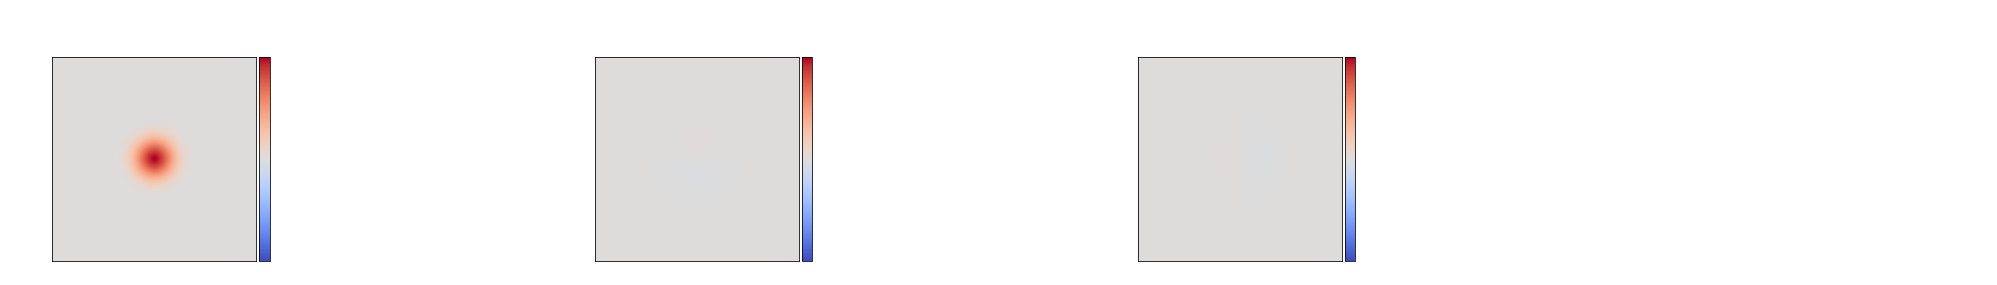

In [20]:
ncAnimation(sim.sim_writer.output_file_name, create_movie=False)

In [21]:
for hour in range(7):
    sim.step(24*3600.0, apply_stochastic_term=False)

In [22]:
anim = ncAnimation(sim.sim_writer.output_file_name)
anim